# **🐍 Proximal Policy Optimisation 🤖**

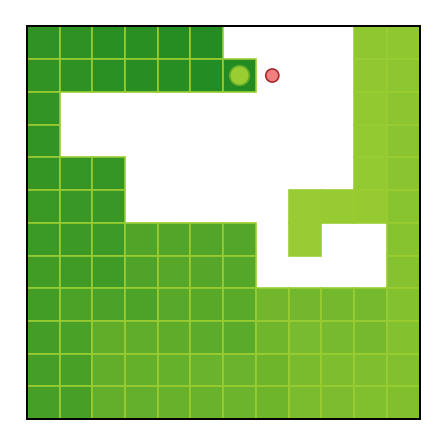

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2025/blob/main/practicals/Reinforcement_Learning/Part_3/RL_practical_2025_Session_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2025. Apache License 2.0.

**Authors:** Siddarth Singh, Sasha Abramowitz, Ruan de Kock, Matthew Morris, Miruna Pîslar

**Introduction:**
Welcome to the third and final session of our Reinforcement Learning practicals!
In this session, we'll take a major step forward by implementing **Proximal Policy Optimisation (PPO)** — one of the most widely used and robust algorithms in modern reinforcement learning.

Building on what you've learned so far, we'll return to the Snake environment to explore how PPO improves upon earlier methods such as **REINFORCE** and **Advantage Actor-Critic (A2C)**. You'll see how PPO stabilizes training through clipped objectives and trust-region-like updates, making it a cornerstone of many high-performance RL systems today.

At its core, PPO strikes a balance between stability and efficiency. By carefully limiting how much the policy can change at each update, it prevents large, destabilising steps while still allowing the agent to learn effectively. This simple yet powerful idea has made PPO a go-to algorithm in both research and real-world applications — from robotics and control to large-scale game environments.

Throughout this practical, you'll implement PPO's key components step by step, observe how its stability mechanisms improve learning, and test your agent in the familiar Snake environment.

By the end of the session, you'll not only have a fully functional PPO agent but also a deep understanding of why it remains one of the most influential algorithms in modern reinforcement learning.

**Learning Objectives:**

By the end of this practical, you will be able to:

*   ✅ **Understand** how PPO improves upon A2C by constraining the size of policy updates.
*   🎲 **Implement** the clipped surrogate objective used in PPO.
*   📈 **Use** advantage estimates and policy ratios to compute the PPO loss.
*   🚀 **Implement** the PPO algorithm end-to-end to train an agent in the Snake environment.
*  🚄 **Learn** About vectorised environments and how they can be used to massively speed up training times.

**Prerequisites:**

To get the most out of this tutorial, you should have some familiarity with:

* [Python](https://www.python.org/) and common libraries like [numpy](https://numpy.org/)
* [JAX](https://github.com/google/jax) for fast, numerical computing and automatic differentiation
* Basic Machine Learning concepts, such as model parameters (weights), gradients, and the softmax function
* [Session 1](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2025/blob/main/practicals/Reinforcement_Learning/Part_1/Solving_the_Snake_game_using_RL.ipynb) and [Session 2](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2025/blob/main/practicals/Reinforcement_Learning/Part_2/RL_practical_2025_Session_2.ipynb) of the RL practical.



### Installs, Imports and Helper Functions
We will also use all the helper functions we defined in the previous practical, without going over them again.

In [ ]:
# @title Install Jumanji (Run me)

%%capture
!pip install jumanji

In [ ]:
# @title Import required packages (Run me)

from typing import NamedTuple

import jumanji
from jumanji.wrappers import JumanjiToGymWrapper, Wrapper, jumanji_to_gym_obs
from jumanji.environments.routing.snake.types import Actions, State, Observation
import gymnasium as gym

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import flax.linen as nn
import optax

import matplotlib.pyplot as plt
import numpy as np
import imageio
from IPython.display import display, Image
import io

from tqdm import notebook


In [ ]:
# @title Utilities (Run me)

# Environment wrapper
class SnakeWrapper(JumanjiToGymWrapper):
  def __init__(self, env):
    super().__init__(env)
    # Flatten the grid observation for simplicity
    self.observation_space["grid"] = gym.spaces.flatten_space(self.observation_space["grid"])

  def reset(self):
    obs, info = super().reset()
    obs["grid"] = obs["grid"].reshape(-1)  # Flatten the last 2 dims of the grid observation for simplicity
    return obs, info

  def step(self, action):
    obs, reward, term, trunc, info = super().step(action)
    obs["grid"] = obs["grid"].reshape(-1)  # Flatten the last 2 dims of the grid observation for simplicity

    # This is a simplicifaction for this tutorial, we use the old Gym API for ease
    # of explaination. For a good discussion around the difference between
    # termination and truncation see:
    # https://farama.org/Gymnasium-Terminated-Truncated-Step-API
    done = term or trunc
    return obs, reward, done, info

# Environment setup
GRID_SIZE = 4  # how big our grid will be
key = jax.random.PRNGKey(42)  # random seed

env = jumanji.make("Snake-v1", num_rows=GRID_SIZE, num_cols=GRID_SIZE)
env = SnakeWrapper(env)  # A friendly environment API

# Environment variables
num_actions = int(env.action_space.n)
observation_shape = env.observation_space['grid'].shape

# Action masking
def mask_illegal_actions(logits, action_mask, negative_action_value=-9999999):
  masked_logits = jnp.where(action_mask, logits, negative_action_value)
  return masked_logits

# Logits to probabilities
def get_action_probabilities(logits):
  return jnp.exp(logits) / jnp.sum(jnp.exp(logits))

# Action sampling
def sample_action(logits, key):
  action_probabilities = get_action_probabilities(logits)
  action = jax.random.choice(
      key, jnp.array([0, 1, 2, 3]), p=action_probabilities
    )
  return action

def select_action(logits, key):
    """Sample an action from the policy distribution."""
    # jax.random.categorical works directly on logits
    return jax.random.categorical(key, logits)

# Policy network
class PolicyNetwork(nn.Module):
  def setup(self):
    self.layer_1 = nn.Dense(16)
    self.layer_2 = nn.Dense(16)
    self.output_layer = nn.Dense(4)

  def __call__(self, observation):
    hidden = self.layer_1(observation)
    hidden = jax.nn.relu(hidden)
    hidden = self.layer_2(observation)
    hidden = jax.nn.relu(hidden)
    logits = self.output_layer(hidden)

    return logits

# Discounted return
def compute_discounted_return(rewards, discount_factor=0.99):
    returns = []
    cumulative_return = 0.0

    # Work backwards through the rewards
    for r in reversed(rewards):
        cumulative_return = r + discount_factor * cumulative_return
        returns.append(cumulative_return)

    # Reverse to get forward chronological order
    returns.reverse()
    return jnp.array(returns)

# Batched policy application
policy_network = PolicyNetwork()
batched_policy_apply = jax.vmap(policy_network.apply, in_axes=(None, 0))

# Log probabilities
def get_action_log_prob(logits, action):
  action_probabilities = get_action_probabilities(logits)
  action_log_prob = jnp.log(action_probabilities[action])
  return action_log_prob

# Batched action probabilities
batched_get_action_log_prob = jax.vmap(get_action_log_prob, in_axes=(0, 0))

# Batched objective function
def batched_reinforce_loss_function(policy_params, observations, actions, discounted_returns):
  batch_logits = batched_policy_apply(policy_params, observations)
  batch_action_log_probabilities = batched_get_action_log_prob(batch_logits, actions)
  reinforce_objective_value = reinforce_objective(batch_action_log_probabilities, discounted_returns)

  return reinforce_objective_value

## A2C and GAE Recap

In the first practical, we introduced REINFORCE. In the previous practical, we built upon it by introducing Actor-Critic methods, and at the end we briefly touched on Generalised Advantage Estimation (GAE).

### REINFORCE
REINFORCE is the canonical example of a *policy gradient method*, and most other methods are built on top of it.
The goal of policy gradient methods is to learn a policy $\pi$ that (1) takes in observations from the environment and then (2) returns the action that maximises the reward the agent obtains.

Recall that our REINFORCE gradient is defined as follows, which we use to "climb the mountain" and update our policy parameters to increase the reward:

$$\nabla_\theta J(\theta)
\propto \mathbb{E}_{\pi_\theta} \left[ Q^\pi(s, a) \, \nabla_\theta \log \pi_\theta(a \mid s) \right] = \mathbb{E}_{\pi_\theta} \left[ G_t \, \nabla_\theta \log \pi_\theta(A_t \mid S_t) \right],$$

where $A_t$ is the agent action at time step $t$, $S_t$ is the state at $t$, and $G_t$ is the return from $t$ onwards.

$A_t, S_t, G_t$ are sampled by repeatedly rolling out the agent in the environment.
In our code, we thus define the following objective function, where $G_t$ = `discounted_returns` and $\log \pi_\theta(A_t \mid S_t)$ = `action_log_probs`.

In [ ]:
# Reinforce objective function
def reinforce_objective(action_log_probs, discounted_returns):
  objective = -(discounted_returns * action_log_probs)
  return jnp.mean(objective)

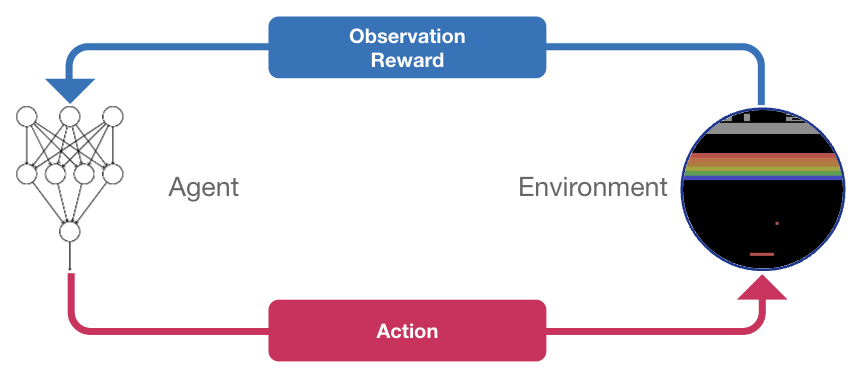

This is the training loop for REINFORCE:

1. Randomly initialise the network parameters $\theta$
2. Start the agent-environment loop. Repeat a specified number of times.
    1. Gather experience for an entire episode.
    2. Compute discounted return $G_t$ from the rewards.
    3. Use the return to update the policy.
    4. Repeat.

Recall that a major problem with REINFORCE is that it has high variance.

### Actor Critic Methods

We decreased the variance of REINFORCE by using a **baseline**. We subtract a **baseline** $b(S_t)$ from the return $G_t$. The baseline can be any function that depends on the state $S_t$, but **not** on the action $A_t$.
A great choice for the baseline is the **state-value function**, $V^\pi(s) = \mathbb{E}_{\pi_\theta} [G_t \mid S_t = s]$. This function tells us the expected return we'll get starting from state $s$ and following our policy $\pi$.

We define the **advantage** as $A^\pi := {G_t - V^\pi(S_t)}$, which measures how much better the agent acted than expected.
Our gradient update becomes:
$$\nabla_\theta J(\theta)
\propto \mathbb{E}_{\pi_\theta} \left[ {A^\pi(S_t, A_t)} \, \nabla_\theta \log \pi_\theta(A_t \mid S_t) \right]$$

This provides a much more stable and focused learning signal. It centers the rewards around zero, helping the agent distinguish between "bad" and "less bad" actions, or "good" and "very good" actions.

We first saw that the advantage can be estimated with Monte Carlo methods, but this was sub-optimal because (1) it assigns the same baseline value to every single state in the episode and (2) it can be very inefficient, especially with long episodes.

We solve this using a **critic network**, which learns to estimate $V^{\pi}(s)$.
We bring everything together by *bootstrapping*, which uses our value function to make an educated guess of the future value of our current state. Then we use this guess and our current reward to update our policy.
This is in contrast to the Monte Carlo approach used in REINFORCE, where you had to wait for the full episode return $G_t$ to update the policy. Bootstrapping allows for online learning from partial rollouts, which solves the latter issue with Monte Carlo methods.

In summary: for our A2C agent, we use a bootstrapped estimate of the advantage $A_t$:

$$\hat A_t = {r_t + \gamma V(s_{t+1})} - V(s_t)$$

Here we can see that:

* The term ${r_t + \gamma V(s_{t+1})}$ is our new, improved estimate for the value of state $s_t$. It's called the **Temporal Difference (TD) Target**. It combines a real, immediate reward ($r_t$) with an ***estimated*** future reward ($\gamma V(s_{t+1})$).

* The entire expression, $(r_t + \gamma V(s_{t+1})) - V(s_t)$, is called the **TD Error**. It measures the difference between our new, better estimate (the TD Target) and our old estimate ($V(s_t)$).

This TD Error is incredibly useful for two reasons:

* **It trains the Critic:** The critic's job is to get better at predicting state values. It does this by trying to minimize the TD Error. A smaller error means its predictions ($V(s_t)$) are getting closer to the target ($r_t + \gamma V(s_{t+1})$).

* **It trains the Actor (i.e. the policy):** The TD Error serves as a much **lower-variance** estimate of the advantage function. Instead of using the high-variance Monte Carlo return ($G_t - V(s_t)$), we now use this TD Error to scale our policy gradients. If the TD error is positive (the action led to a better-than-expected outcome), we increase the probability of taking that action. If it's negative, we decrease it.

This forms the core of our **Advantage Actor-Critic** (A2C) agent. We use a single, bootstrapped value to update both the actor and the critic simultaneously.

### Generalised Advantage Estimation (GAE)

The problem with bootstrapping is that it results in a low variance, but high bias estimate (it puts us in the bottom left quadrant of the bias-variance trade-off image).

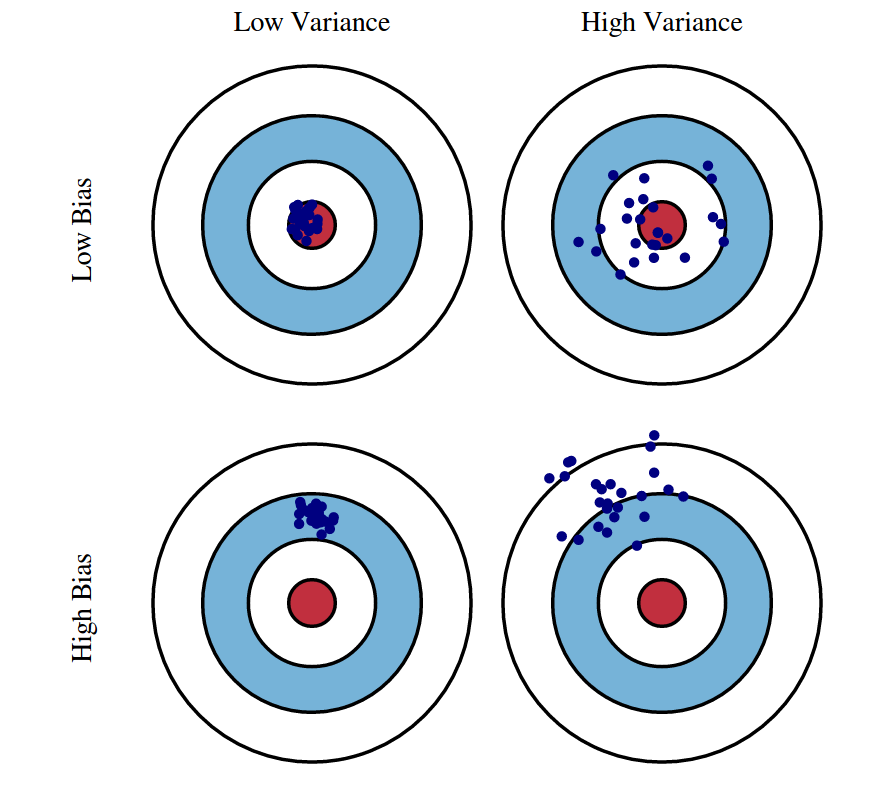

This can lead to suboptimal policies. On the other hand, using Monte-Carlo rollouts (as we did in REINFORCE) has a high variance and can also lead to sub-optimal results (top right of the bias-variance trade-off image).
The solution here is to find a balance between bootstrapping and Monte-Carlo rollouts and luckily an algorithm for this already exists: Generalised Advantages Estimation (GAE)!

**GAE** uses a single parameter $\lambda$ to control the bias-variance trade-off, where:
* $\lambda=1$ is equivalent to Monte-Carlo returns
* $\lambda=0$ is equivalent to bootstrapping
* $\lambda=0.95$ is a good value in general

At the end of the last practical, we defined a method to calculate the GAE:

In [ ]:
def calculate_gae(
  rewards: np.ndarray,  # shape: (T,)
  values: np.ndarray,   # shape: (T+1,) this contains the final value V_{t+1}
  dones: np.ndarray,    # shape: (T,)
  gamma: float = 0.99,  # shape: (1,)
  gae_lambda: float = 0.95, # shape: (1,)
):
    """
    Calculates the Generalized Advantage Estimation (GAE) for a trajectory.

    Returns:
        np.ndarray: The calculated advantages for each step in the trajectory.
    """
    num_steps = len(rewards)
    advantages = jnp.zeros_like(rewards, dtype=jnp.float32)
    next_advantage = 0.0

    # Iterate backwards from the last step to the first
    for t in reversed(range(num_steps)):
        # The mask is 0 if the state is terminal (done=True), and 1 otherwise.
        # This handles resetting the advantage calculation at episode boundaries.
        mask = 1.0 - dones[t]

        # Calculate the TD error (delta) for the current step
        # delta_t = r_t + gamma * V(s_{t+1}) - V(s_t)
        # V(s_{t+1}) is masked to 0 if the episode ended.
        delta = rewards[t] + gamma * values[t + 1] * mask - values[t]

        # Calculate the advantage using the recursive GAE formula
        # A_t = delta_t + gamma * lambda * A_{t+1}
        # The advantage from the next step (next_advantage) is also masked.
        advantages = advantages.at[t].set(delta + gamma * gae_lambda * next_advantage * mask)
        next_advantage = advantages[t]

    return advantages

## [Exercise] Use GAE in A2C
First, we compute advantages as we did in the last practical:

In [ ]:
# TD(0) advantages
def compute_advantages(rew_b, values, next_values, done_b, gamma):
    next_values = next_values * (1.0 - done_b)
    target_values = rew_b + gamma * next_values
    return target_values - values

In [ ]:
#@title A2C Training Code (run me)

def a2c_loss_fn(params, observations, actions, rewards, advantages, target_values):
    """Calculates the combined actor-critic loss."""

    # Network outputs
    logits, values = jax.vmap(ac_network.apply, in_axes=(None, 0))(params, observations)

    # Critic loss
    critic_loss = 0.5 * jnp.mean((target_values - values) ** 2)

    # Actor loss
    log_probs = nn.log_softmax(logits)
    action_log_probs = jax.vmap(lambda lp, a: lp[a])(log_probs, actions)
    actor_loss = -jnp.mean(action_log_probs * advantages)

    return actor_loss + critic_loss

# 2. Create Actor-Critic Network
class ActorCriticNetwork(nn.Module):
    """An actor-critic network that shares the initial layers."""
    @nn.compact
    def __call__(self, observation):
        # Shared layers
        hidden = nn.Dense(64)(observation.flatten()) # Flatten the grid observation
        hidden = nn.relu(hidden)
        hidden = nn.Dense(64)(hidden)
        hidden = nn.relu(hidden)

        # Actor head (policy)
        actor_logits = nn.Dense(num_actions)(hidden)

        # Critic head (value)
        critic_value = nn.Dense(1)(hidden)

        return actor_logits, jnp.squeeze(critic_value)

# 3. Training Setup
learning_rate = 3e-4
gamma = 0.99
total_num_episodes = 50
update_threshold = 64 # The number of transitions to collect before an update

# Initialize the network and optimizer
ac_network = ActorCriticNetwork()
dummy_obs = jnp.ones(observation_shape)
key, network_init_key = jax.random.split(key)
params = ac_network.init(network_init_key, dummy_obs)

optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, opt_state, observations, actions, rewards, advantages, target_values):
    loss, grads = jax.value_and_grad(a2c_loss_fn)(
        params, observations, actions, rewards, advantages, target_values
    )
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, loss

obs_buffer, act_buffer, rew_buffer, next_obs_buffer, done_buffer = [], [], [], [], []

# 4. Agent-Environment Interaction and Training Loop
for episode in range(total_num_episodes):
    obs, info = env.reset()
    done = False
    episode_return = 0

    while not done:
        grid_obs = obs['grid']
        key, action_key = jax.random.split(key)

        # Get action from the current policy
        logits, _ = ac_network.apply(params, grid_obs)
        masked_logits = mask_illegal_actions(logits, obs['action_mask'])
        action = select_action(masked_logits, action_key)

        # Step the environment
        next_obs, reward, done, info = env.step(action.item())
        grid_next_obs = next_obs['grid']

        # Add the new, on-policy transition to the temporary buffer
        obs_buffer.append(grid_obs)
        act_buffer.append(action)
        rew_buffer.append(reward)
        next_obs_buffer.append(grid_next_obs)
        done_buffer.append(done)

        episode_return += reward
        obs = next_obs

        # Train and reset the buffer if the threshold is reached
        if len(obs_buffer) == update_threshold:
            obs_b = jnp.array(obs_buffer)
            act_b = jnp.array(act_buffer)
            rew_b = np.array(rew_buffer, dtype=np.float32)
            next_obs_b = jnp.array(next_obs_buffer)
            done_b = np.array(done_buffer, dtype=np.float32)

            # Compute values for states and next states
            values = jax.vmap(ac_network.apply, in_axes=(None, 0))(params, obs_b)[1]
            next_values = jax.vmap(ac_network.apply, in_axes=(None, 0))(params, next_obs_b)[1]

            # --- Compute advantages ---
            advantages = compute_advantages(
                rew_b=rew_b,
                values=np.array(values),
                next_values=np.array(next_values),
                done_b=done_b,
                gamma=gamma
            )
            advantages = jnp.array(advantages)
            target_values = advantages + values

            # Train
            params, opt_state, loss = train_step(params, opt_state, obs_b, act_b, rew_b, advantages, target_values)

            # Reset buffer
            obs_buffer, act_buffer, rew_buffer, next_obs_buffer, done_buffer = [], [], [], [], []

    if episode % 1 == 0:
        print(f"Episode {episode} | Return: {episode_return:<4}")

Episode 0 | Return: 6.0 
Episode 1 | Return: 11.0
Episode 2 | Return: 7.0 
Episode 3 | Return: 15.0
Episode 4 | Return: 7.0 
Episode 5 | Return: 11.0
Episode 6 | Return: 4.0 
Episode 7 | Return: 10.0
Episode 8 | Return: 7.0 
Episode 9 | Return: 4.0 
Episode 10 | Return: 10.0
Episode 11 | Return: 8.0 
Episode 12 | Return: 11.0
Episode 13 | Return: 4.0 
Episode 14 | Return: 6.0 
Episode 15 | Return: 5.0 
Episode 16 | Return: 8.0 
Episode 17 | Return: 10.0
Episode 18 | Return: 7.0 
Episode 19 | Return: 9.0 
Episode 20 | Return: 9.0 
Episode 21 | Return: 9.0 
Episode 22 | Return: 7.0 
Episode 23 | Return: 6.0 
Episode 24 | Return: 7.0 
Episode 25 | Return: 6.0 
Episode 26 | Return: 9.0 
Episode 27 | Return: 4.0 
Episode 28 | Return: 4.0 
Episode 29 | Return: 4.0 
Episode 30 | Return: 10.0
Episode 31 | Return: 10.0
Episode 32 | Return: 6.0 
Episode 33 | Return: 4.0 
Episode 34 | Return: 4.0 
Episode 35 | Return: 11.0
Episode 36 | Return: 6.0 
Episode 37 | Return: 7.0 
Episode 38 | Return: 9

Now, redefine the `compute_advantages` function to compute GAE advantages using our `calculate_gae` function.

**Once you are done, re-run the A2C training code to make sure it works.**

In [ ]:
#@title Exercise (complete the code)

# GAE advantages
def compute_advantages(rew_b, values, next_values, done_b, gamma, gae_lambda=0.95):
    """
    Wrapper around calculate_gae to compute advantages with GAE.

    Args:
        rew_b: rewards, shape (T,)
        values: state values V(s_t), shape (T,)
        next_values: state values V(s_{t+1}), shape (T,)
        done_b: done flags, shape (T,)
        gamma: discount factor
        gae_lambda: GAE lambda parameter

    Returns:
        np.ndarray of advantages, shape (T,)
    """
    # Extend values so it has length T+1 (needed by calculate_gae)
    values_ext = np.concatenate([np.array(values), np.array([next_values[-1]])])

    advantages = calculate_gae(
        rewards=np.array(rew_b),
        values=values_ext,
        dones=np.array(done_b),
        gamma=gamma,
        gae_lambda=gae_lambda
    )

    return advantages

In [ ]:
#@title Answer to Exercise

# GAE advantages
def compute_advantages(rew_b, values, next_values, done_b, gamma, gae_lambda=0.95):
    """
    Wrapper around calculate_gae to compute advantages with GAE.

    Args:
        rew_b: rewards, shape (T,)
        values: state values V(s_t), shape (T,)
        next_values: state values V(s_{t+1}), shape (T,)
        done_b: done flags, shape (T,)
        gamma: discount factor
        gae_lambda: GAE lambda parameter

    Returns:
        np.ndarray of advantages, shape (T,)
    """
    # Extend values so it has length T+1 (needed by calculate_gae)
    values_ext = jnp.concatenate([jnp.array(values), jnp.array([next_values[-1]])])

    advantages = calculate_gae(
        rewards=jnp.array(rew_b),
        values=values_ext,
        dones=jnp.array(done_b),
        gamma=gamma,
        gae_lambda=gae_lambda
    )

    return advantages

## **From A2C to PPO: The Problem with Step Size**

In the previous section, we explored **Advantage Actor-Critic (A2C)**, an algorithm that learns by "nudging" its policy in profitable directions. This works well, but a critical question remains:

> **How big should that "nudge" be?**

### The Mountain Range Analogy

Think of the landscape of possible policies like a mountain range with many peaks and valleys:

- A2C uses the **gradient** to point us in the "uphill" direction
- But it **doesn't specify how far to step**
- If we take too large a step, we risk **overshooting** the true peak

<div align="center">

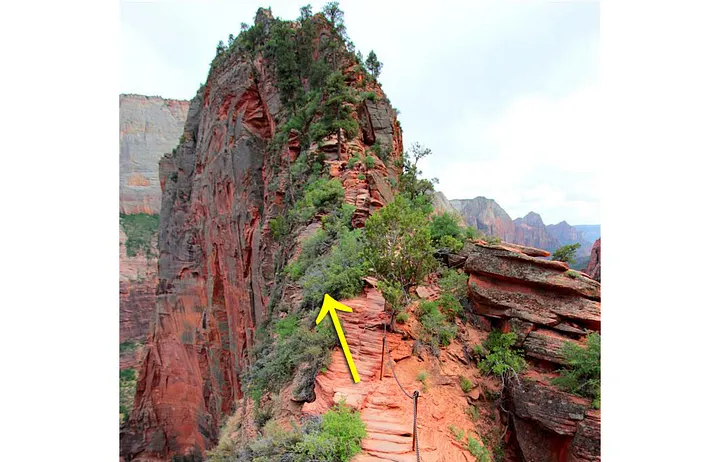

*One large leap might send you over the edge!*

</div>

### The Problem: Getting Stuck in Bad Local Optima

When we take a step that's too large:
1. We might land in a deep valley—a **poor local optimum**
2. From there, any small change seems to make things worse
3. The agent becomes **stuck** and stops improving

This is a classic problem in optimization: **a locally greedy choice can prevent us from finding the globally best solution.**

### The Solution: Trust Regions

Instead of taking a potentially reckless leap, we introduce a **trust region**:

- We constrain the policy update to a small, "trusted" area
- We only search for improvements around our current, known-good policy
- This allows for **more stable and reliable progress**

<div align="center">

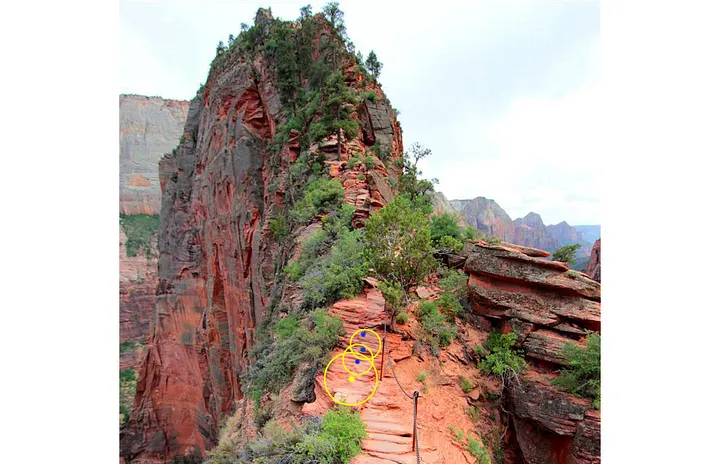

*Many small, careful steps safely reach the summit!*

</div>

**This principle of constrained, cautious optimization is the core innovation behind Proximal Policy Optimization (PPO).**

### Visualizing the Policy Landscape

To make this concrete, let's visualize the problem. We'll create a simple 1D reward function that represents our policy landscape with two peaks:

- **A narrow, steep peak** (the optimal policy we want to find)
- **A wider, lower peak** (a suboptimal local optimum)

Our goal is to find the highest peak. We'll simulate a basic **gradient ascent optimizer** (the core of A2C's update) with a relatively high learning rate, starting it near the optimal peak.

**Watch what happens when the step size is too large...**

**Note:** In this simplified example, `x` represents a single policy parameter (like one weight in a neural network). In real RL, your policy has thousands or millions of parameters, but the same overshooting problem occurs in high-dimensional space—it's just impossible to visualize!

Starting at x = 1.50, Reward = 0.65
Step  1: Grad=1.15, Update=2.30 -> New x=3.80, Reward=0.00
Step  2: Grad=-0.01, Update=-0.02 -> New x=3.78, Reward=0.00
Step  3: Grad=-0.01, Update=-0.03 -> New x=3.75, Reward=0.00
Step  4: Grad=-0.02, Update=-0.03 -> New x=3.72, Reward=0.00
Step  5: Grad=-0.02, Update=-0.04 -> New x=3.68, Reward=0.00
Step  6: Grad=-0.02, Update=-0.05 -> New x=3.63, Reward=0.01
Step  7: Grad=-0.03, Update=-0.07 -> New x=3.57, Reward=0.01
Step  8: Grad=-0.05, Update=-0.10 -> New x=3.47, Reward=0.01
Step  9: Grad=-0.08, Update=-0.16 -> New x=3.31, Reward=0.03
Step 10: Grad=-0.17, Update=-0.34 -> New x=2.98, Reward=0.15


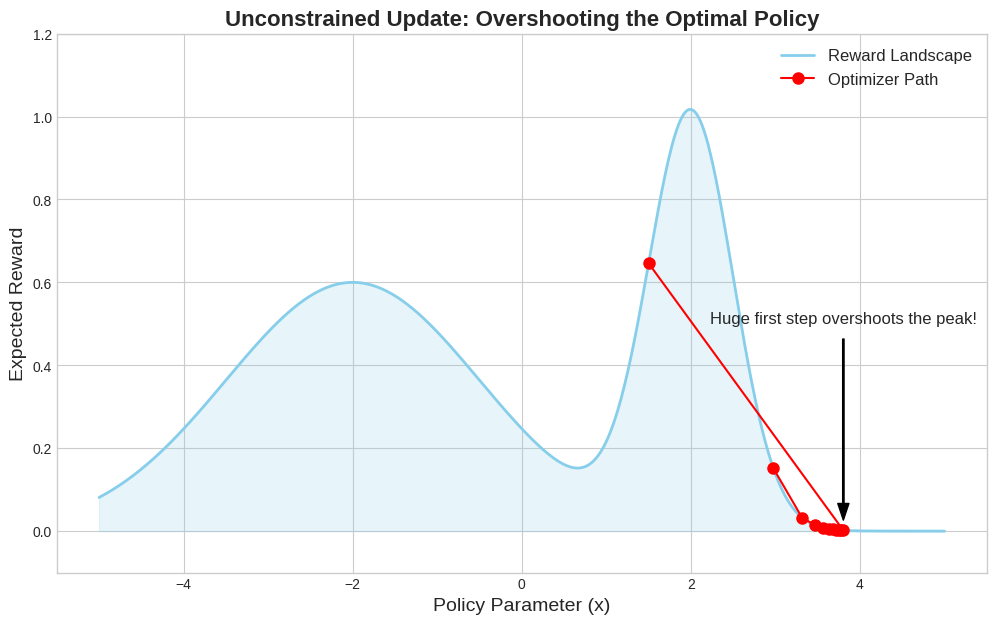

In [ ]:
# @title Simulate unconstrained gradient update

import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the Reward Landscape ---
# We create a function with two "peaks" (optima).
# One peak is high and narrow (the global optimum we want to find).
# The other is lower and wider (a suboptimal local optimum).
def reward_landscape(x):
    """A function with a global and a local optimum."""
    global_optimum = 1.0 * np.exp(-((x - 2.0)**2) / (2 * 0.5**2))
    local_optimum = 0.6 * np.exp(-((x + 2.0)**2) / (2 * 1.5**2))
    return global_optimum + local_optimum

# --- 2. Define the Gradient ---
# This is the derivative of our landscape, which tells us the "uphill" direction.
def gradient(x):
    """The gradient (derivative) of the reward landscape."""
    # Accurate gradient calculation for the sum of gaussians:
    grad_global = -((x - 2.0) / 0.5**2) * (1.0 * np.exp(-((x - 2.0)**2) / (2 * 0.5**2)))
    grad_local = -((x + 2.0) / 1.5**2) * (0.6 * np.exp(-((x + 2.0)**2) / (2 * 1.5**2)))
    return grad_global + grad_local


# --- 3. Simulation Hyperparameters ---
learning_rate = 2.0  # A high learning rate to show instability
n_steps = 10
start_point = 1.5   # Start on the steep slope of the global optimum

# --- 4. Run the Unconstrained Optimization ---
x_history = [start_point]
y_history = [reward_landscape(start_point)]

current_x = start_point
print(f"Starting at x = {current_x:.2f}, Reward = {y_history[0]:.2f}")

for i in range(n_steps):
    # Calculate gradient and take a large, unconstrained step
    grad = gradient(current_x)
    update = learning_rate * grad
    current_x += update

    # Store history for plotting
    x_history.append(current_x)
    y_history.append(reward_landscape(current_x))
    print(f"Step {i+1:2d}: Grad={grad:.2f}, Update={update:.2f} -> New x={current_x:.2f}, Reward={y_history[-1]:.2f}")

# --- 5. Visualize the Result ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the landscape
x_smooth = np.linspace(-5, 5, 500)
y_smooth = reward_landscape(x_smooth)
ax.plot(x_smooth, y_smooth, label='Reward Landscape', color='skyblue', linewidth=2)
ax.fill_between(x_smooth, y_smooth, alpha=0.2, color='skyblue')

# Plot the optimizer's path
ax.plot(x_history, y_history, 'o-', c='red', label='Optimizer Path', markersize=8)

# Highlight the catastrophic first step
ax.annotate('Huge first step overshoots the peak!',
            xy=(x_history[1], y_history[1]),
            xytext=(x_history[1], y_history[1] + 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
            fontsize=12, ha='center')

# Add labels and title
ax.set_xlabel("Policy Parameter (x)", fontsize=14)
ax.set_ylabel("Expected Reward", fontsize=14)
ax.set_title("Unconstrained Update: Overshooting the Optimal Policy", fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.set_ylim(-0.1, 1.2)

plt.show()

### Why Does This Happen?

As the visualization clearly shows, our optimizer's journey was short and disastrous. Let's break down what went wrong:

#### **Step 1: A Promising Start** ✓
- Started on the slope of the highest peak
- The gradient was steep and pointed in the right direction
- Everything looked good...

#### **Step 2: The Catastrophic Leap** ✗
- Because our `learning_rate` was high, the first update was a **massive leap**
- This single step caused the optimizer to **completely overshoot** the true optimal policy (the peak at x=2.0)
- It landed in the valley on the other side

#### **Step 3: Trapped in a Local Optimum** ✗
Once in the valley, the optimizer was **trapped**:
- The gradients now pointed toward the nearest peak
- This peak was much smaller (suboptimal)
- The optimizer successfully "climbed" this wrong hill
- It got stuck there, never able to return to the true global optimum

---

### The Key Takeaway

This demonstrates the **central weakness of simple policy gradient methods**:

> **They are highly sensitive to the scale of the update.**

A locally-correct gradient direction, when combined with a large step size, can lead to a globally catastrophic outcome. The gradient tells us which way is "up," but it doesn't tell us how far we can safely step before the landscape changes underneath us.

**This is exactly the problem PPO was designed to solve.**

## The Solution: Implementing a Trust Region

As the visualization clearly shows, our optimizer failed because **one massive step, driven by a steep gradient, overshot the optimal policy entirely.** It was a locally greedy choice that led to a globally poor result.

This is the exact problem that **Trust Regions** are designed to solve.

### The Core Idea

The concept is beautifully simple:

> **We should only "trust" our gradient information in a small neighborhood around our current policy.**

Instead of blindly following the gradient for any distance, we add a constraint to our update rule:

**Do not allow the new policy to be too different from the old one.**

By enforcing this constraint, we prevent destructive leaps and ensure more stable learning.

---

## 🎯 Your Task: Implement the Trust Region Constraint

Now it's your turn to fix the optimizer! In the code cell below, you'll add **one line of code** that enforces our trust region.

### Instructions

1. **Find** the comment block labeled `*** YOUR TASK IS HERE ***`

2. **Understand** what you have:
   - `proposed_step` has already been calculated (this is the potentially "dangerous" step)
   - `max_step_size` defines our trust region boundary

3. **Implement** the constraint:
   - Compute `actual_step` by **clipping** the `proposed_step` to stay within bounds
   - The step cannot be larger than `+max_step_size` or smaller than `-max_step_size`

### 💡 Hint

NumPy has a perfect function for this: `np.clip(a, a_min, a_max)`

This function takes a value `a` and ensures it stays between `a_min` and `a_max`.

### ✓ Success Criteria

If your implementation is correct, the resulting plot should show the optimizer:
- Taking **small, controlled steps**
- Successfully reaching the **highest peak** (global optimum)
- **Avoiding the overshoot** we saw in the first simulation

Give it a try!

In [ ]:
# @title Trust Region Rescue Simulation (EXERCISE)

import numpy as np
import matplotlib.pyplot as plt

# --- 1. Re-use the same Landscape and Gradient from before ---
def reward_landscape(x):
    """A function with a global and a local optimum."""
    global_optimum = 1.0 * np.exp(-((x - 2.0)**2) / (2 * 0.5**2))
    local_optimum = 0.6 * np.exp(-((x + 2.0)**2) / (2 * 1.5**2))
    return global_optimum + local_optimum

def gradient(x):
    """The gradient (derivative) of the reward landscape."""
    grad_global = -((x - 2.0) / 0.5**2) * (1.0 * np.exp(-((x - 2.0)**2) / (2 * 0.5**2)))
    grad_local = -((x + 2.0) / 1.5**2) * (0.6 * np.exp(-((x + 2.0)**2) / (2 * 1.5**2)))
    return grad_global + grad_local


# --- 2. Use the SAME Hyperparameters, but add the Trust Region ---
learning_rate = 2.0      # The same high learning rate that previously failed
n_steps = 20             # More steps to see convergence
start_point = 1.5        # The same starting point
max_step_size = 0.4      # Our trust region radius. Max allowed change per step.

# --- 3. Run the CONSTRAINED Optimization ---
x_history_tr = [start_point]
y_history_tr = [reward_landscape(start_point)]

current_x = start_point
print(f"Starting at x = {current_x:.2f}, Reward = {y_history_tr[0]:.2f}")

for i in range(n_steps):
    # Calculate the gradient
    grad = gradient(current_x)

    # Propose a step (this could be large and dangerous)
    proposed_step = learning_rate * grad

    # *** YOUR TASK IS HERE ***
    # Clip the proposed step to be within our maximum allowed size.
    # Replace the line below with the correct code to calculate the actual_step
    # Hint: Use np.clip
    actual_step = proposed_step  # <-- REPLACE THIS LINE WITH YOUR CODE

    # Take the safe, actual step
    current_x += actual_step

    # Store history for plotting
    x_history_tr.append(current_x)
    y_history_tr.append(reward_landscape(current_x))
    print(f"Step {i+1:2d}: Proposed={proposed_step:.2f}, Clipped={actual_step:.2f} -> New x={current_x:.2f}, Reward={y_history_tr[-1]:.2f}")


# --- 4. Visualize the Result ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the landscape
x_smooth = np.linspace(-5, 5, 500)
y_smooth = reward_landscape(x_smooth)
ax.plot(x_smooth, y_smooth, label='Reward Landscape', color='skyblue', linewidth=2)
ax.fill_between(x_smooth, y_smooth, alpha=0.2, color='skyblue')

# Plot the optimizer's path
ax.plot(x_history_tr, y_history_tr, 'o-', c='green', label='Optimizer Path (Constrained)', markersize=8, linewidth=2)

# Highlight the trust region for the first step
ax.axvspan(start_point - max_step_size, start_point + max_step_size,
           color='orange', alpha=0.3, label=f'Trust Region at Start (size={max_step_size})')

# Add annotation
ax.annotate('Small, safe steps\nto the global optimum!',
            xy=(x_history_tr[-1], y_history_tr[-1]),
            xytext=(x_history_tr[-1] - 1, y_history_tr[-1] + 0.3),
            arrowprops=dict(facecolor='green', shrink=0.05, width=1, headwidth=8),
            fontsize=12, ha='center')

# Add labels and title
ax.set_xlabel("Policy Parameter (x)", fontsize=14)
ax.set_ylabel("Expected Reward", fontsize=14)
ax.set_title("Constrained Update: Safely Converging with a Trust Region", fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.set_ylim(-0.1, 1.2)

plt.show()

In [ ]:
# @title Trust Region Rescue Simulation (ANSWER)

import numpy as np
import matplotlib.pyplot as plt

# --- 1. Re-use the same Landscape and Gradient from before ---
def reward_landscape(x):
    """A function with a global and a local optimum."""
    global_optimum = 1.0 * np.exp(-((x - 2.0)**2) / (2 * 0.5**2))
    local_optimum = 0.6 * np.exp(-((x + 2.0)**2) / (2 * 1.5**2))
    return global_optimum + local_optimum

def gradient(x):
    """The gradient (derivative) of the reward landscape."""
    grad_global_correct = -((x - 2.0) / 0.5**2) * (1.0 * np.exp(-((x - 2.0)**2) / (2 * 0.5**2)))
    grad_local_correct = -((x + 2.0) / 1.5**2) * (0.6 * np.exp(-((x + 2.0)**2) / (2 * 1.5**2)))
    return grad_global_correct + grad_local_correct


# --- 2. Use the SAME Hyperparameters, but add the Trust Region ---
learning_rate = 2.0      # The same high learning rate that previously failed
n_steps = 10
start_point = 1.5      # The same starting point
max_step_size = 0.4    # NEW: Our trust region radius. Max allowed change per step.

# --- 3. Run the CONSTRAINED Optimization ---
x_history_tr = [start_point]
y_history_tr = [reward_landscape(start_point)]

current_x = start_point
print(f"Starting at x = {current_x:.2f}, Reward = {y_history_tr[0]:.2f}")

for i in range(n_steps):
    # Calculate the gradient
    grad = gradient(current_x)

    # Propose a step (this could be large and dangerous)
    proposed_step = learning_rate * grad

    # *** THIS IS THE TRUST REGION ***
    # Clip the proposed step to be within our maximum allowed size.
    actual_step = np.clip(proposed_step, -max_step_size, max_step_size)

    # Take the safe, actual step
    current_x += actual_step

    # Store history for plotting
    x_history_tr.append(current_x)
    y_history_tr.append(reward_landscape(current_x))
    print(f"Step {i+1:2d}: Proposed={proposed_step:.2f}, Clipped={actual_step:.2f} -> New x={current_x:.2f}, Reward={y_history_tr[-1]:.2f}")


# --- 4. Visualize the Result ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the landscape
x_smooth = np.linspace(-5, 5, 500)
y_smooth = reward_landscape(x_smooth)
ax.plot(x_smooth, y_smooth, label='Reward Landscape', color='skyblue', linewidth=2)
ax.fill_between(x_smooth, y_smooth, alpha=0.2, color='skyblue')

# Plot the optimizer's path
ax.plot(x_history_tr, y_history_tr, 'o-', c='green', label='Optimizer Path (Constrained)', markersize=8)

# Highlight the trust region for the first step
ax.axvspan(start_point - max_step_size, start_point + max_step_size,
           color='orange', alpha=0.3, label=f'Trust Region at Start (size={max_step_size})')

# Add annotation
ax.annotate('Steps are now constrained,\npreventing overshoot!',
            xy=(x_history_tr[1], y_history_tr[1]),
            xytext=(x_history_tr[1] - 1.5, y_history_tr[1] + 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
            fontsize=12, ha='center')

# Add labels and title
ax.set_xlabel("Policy Parameter (x)", fontsize=14)
ax.set_ylabel("Expected Reward", fontsize=14)
ax.set_title("Constrained Update: Safely Converging with a Trust Region", fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.set_ylim(-0.1, 1.2)

plt.show()

### Conclusion and Bridge to PPO

And there we have it. The two simulations tell a clear story:

- An unconstrained update, driven by a steep gradient, can be dangerously unstable. It risks overshooting good policies and getting trapped in bad ones.

- A constrained update, using a trust region to limit the step size, provides the necessary stability to navigate the policy landscape safely and effectively, allowing the optimizer to converge reliably.

This is the core intuition behind Proximal Policy Optimization (PPO). This stability is not just about avoiding failure; it's also about efficiency. Because PPO ensures the policy doesn't change drastically, it can safely reuse the same batch of collected experience for multiple training epochs. This is a key advantage that makes PPO significantly more sample-efficient than simpler policy gradient methods like A2C, which typically discard data after a single update.

So, how does PPO enforce this trust region and enable multiple updates without a simple hard clip like we used? It does so through a clever objective function, often called the Clipped Surrogate Objective.

In the next section, we'll first explain the high-level mechanics of PPO. Then, you'll get to implement this crucial clipped objective function yourself and visualize how it works to create the stability we need.

For some additional intuition you can compare the constrained and unconstrained gradient optimisation below. Notice how with higher learning rates the unconstrained gradient gets stuck in multiple local minima where as the contrained gradient is uneffected.

In [ ]:
# @title Interactive comparison of unconstrained vs. constrained updates (with arrows)

from ipywidgets import interact, FloatSlider
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Use the same reward landscape and gradient ---
def reward_landscape(x):
    """A function with a global and a local optimum."""
    global_optimum = 1.0 * np.exp(-((x - 2.0)**2) / (2 * 0.5**2))
    local_optimum = 0.6 * np.exp(-((x + 2.0)**2) / (2 * 1.5**2))
    return global_optimum + local_optimum

def gradient(x):
    """The gradient (derivative) of the reward landscape."""
    grad_global_correct = -((x - 2.0) / 0.5**2) * (1.0 * np.exp(-((x - 2.0)**2) / (2 * 0.5**2)))
    grad_local_correct = -((x + 2.0) / 1.5**2) * (0.6 * np.exp(-((x + 2.0)**2) / (2 * 1.5**2)))
    return grad_global_correct + grad_local_correct

# --- 2. Create a function that runs both simulations and plots them ---
def plot_optimizer_comparison(learning_rate, start_point, max_step_size):
    n_steps = 10

    # --- Run Unconstrained Simulation ---
    x_hist_unconstrained = [start_point]
    y_hist_unconstrained = [reward_landscape(start_point)]
    current_x_uc = start_point
    for _ in range(n_steps):
        grad_uc = gradient(current_x_uc)
        current_x_uc += learning_rate * grad_uc
        x_hist_unconstrained.append(current_x_uc)
        y_hist_unconstrained.append(reward_landscape(current_x_uc))

    # --- Run Constrained Simulation ---
    x_hist_constrained = [start_point]
    y_hist_constrained = [reward_landscape(start_point)]
    current_x_c = start_point
    for _ in range(n_steps):
        grad_c = gradient(current_x_c)
        proposed_step = learning_rate * grad_c
        actual_step = np.clip(proposed_step, -max_step_size, max_step_size)
        current_x_c += actual_step
        x_hist_constrained.append(current_x_c)
        y_hist_constrained.append(reward_landscape(current_x_c))

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    x_smooth = np.linspace(-5, 5, 500)
    y_smooth = reward_landscape(x_smooth)
    ax.plot(x_smooth, y_smooth, label='Reward Landscape', color='skyblue', linewidth=2)
    ax.fill_between(x_smooth, y_smooth, alpha=0.2, color='skyblue')

    # Plot Unconstrained Path with Arrows
    # Plot first point
    ax.plot(x_hist_unconstrained[0], y_hist_unconstrained[0], 'o', c='red', markersize=8, alpha=0.8, label='Unconstrained Path')
    for i in range(len(x_hist_unconstrained) - 1):
        x1, y1 = x_hist_unconstrained[i], y_hist_unconstrained[i]
        x2, y2 = x_hist_unconstrained[i+1], y_hist_unconstrained[i+1]
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.05, width=1, headwidth=8))
        if i < len(x_hist_unconstrained) - 2: # Plot intermediate points
             ax.plot(x2, y2, 'o', c='red', markersize=4, alpha=0.8)


    # Plot Constrained Path with Arrows
    # Plot first point
    ax.plot(x_hist_constrained[0], y_hist_constrained[0], 's', c='green', markersize=8, alpha=0.8, label='Constrained Path (Trust Region)')
    for i in range(len(x_hist_constrained) - 1):
        x1, y1 = x_hist_constrained[i], y_hist_constrained[i]
        x2, y2 = x_hist_constrained[i+1], y_hist_constrained[i+1]
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(facecolor='green', edgecolor='green', shrink=0.05, width=1, headwidth=8))
        if i < len(x_hist_constrained) - 2: # Plot intermediate points
            ax.plot(x2, y2, 's', c='green', markersize=4, alpha=0.8)

    ax.set_xlabel("Policy Parameter (x)", fontsize=14)
    ax.set_ylabel("Expected Reward", fontsize=14)
    ax.set_title("Interactive Optimizer Comparison", fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.set_ylim(-0.1, 1.3)
    plt.show()

# --- 3. Create the interactive widget ---
interact(
    plot_optimizer_comparison,
    learning_rate=FloatSlider(value=2.0, min=0.1, max=4.0, step=0.1, description='Learning Rate'),
    start_point=FloatSlider(value=1.5, min=-4.0, max=4.0, step=0.1, description='Start Point'),
    max_step_size=FloatSlider(value=0.4, min=0.05, max=3.0, step=0.05, description='Max Step Size')
);

## From Trust Regions to PPO

The previous example showed that constraining updates to a 'trust region' prevents catastrophic steps and improves stability. While manually clipping the update step worked, a more principled approach is to build this constraint directly into the objective function.

This is the core idea behind **Proximal Policy Optimization (PPO)**: modifying the objective to disincentivise large policy changes.


### The PPO clipped surrogate objective

Instead of working with log-probabilities like in A2C, PPO uses a probability ratio between the new policy ($\pi_\theta$) and the old policy that collected the data ($\pi_{\theta_{old}}$):

$$r_t(\theta) = \frac{\pi_\theta(a_t \mid s_t)}{\pi_{\theta_{old}}(a_t \mid s_t)}$$

This ratio measures how the new policy changes the probability of an action. A naive objective would be to maximize $r_t(\theta) \cdot A_t$, but this is unbounded and suffers from the same instability as A2C.

PPO's solution is the **clipped surrogate objective**, which constrains how much the ratio can change:

$$ L^{\text{CLIP}}(\theta) = \mathbb{E}_t \left[ \min\left( r_t(\theta) A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t \right) \right] $$

Here, $\epsilon$ is a small hyperparameter (e.g., 0.2). The `min` function effectively creates the trust region:

1.  **If Advantage is Positive ($A_t > 0$):** The objective increases as we make a good action more likely (increasing $r_t$). However, the `clip` term prevents the objective from improving if $r_t$ exceeds $1+\epsilon$. This caps the potential update, preventing an overly large step.

2.  **If Advantage is Negative ($A_t < 0$):** The objective becomes more negative (a larger penalty) as we make a bad action less likely (decreasing $r_t$). The `clip` term prevents the penalty from worsening if $r_t$ goes below $1-\epsilon$. This limits how much we can penalize the policy, avoiding over-correction.

This clipping is the heart of PPO. It creates a soft trust region in the objective, ensuring stable updates.

### Visualizing the clipped objective

Let's visualize the PPO objective. Run the code below and notice how the objective flattens out when the ratio $r_t$ goes beyond the clipping boundaries ($1 \pm \epsilon$). This removes the incentive for the optimizer to make excessively large policy changes, leading to stability.

In [ ]:
# @title PPO Loss Visualization (run me)
import numpy as np
import matplotlib.pyplot as plt

def visualize_ppo_loss():
    epsilon = 0.2
    ratios = np.linspace(0.5, 2.0, 200)

    # Positive advantage
    advantage_pos = 1.5
    unclipped_obj_pos = ratios * advantage_pos
    clipped_obj_pos = np.clip(ratios, 1 - epsilon, 1 + epsilon) * advantage_pos
    final_obj_pos = np.minimum(unclipped_obj_pos, clipped_obj_pos)

    # Negative advantage
    advantage_neg = -1.0
    unclipped_obj_neg = ratios * advantage_neg
    clipped_obj_neg = np.clip(ratios, 1 - epsilon, 1 + epsilon) * advantage_neg
    final_obj_neg = np.minimum(unclipped_obj_neg, clipped_obj_neg)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('PPO Clipped Surrogate Objective', fontsize=18, fontweight='bold')

    ax1.plot(ratios, unclipped_obj_pos, 'g--', label='Unclipped Objective ($r_t A_t$)')
    ax1.plot(ratios, final_obj_pos, 'b-', linewidth=2.5, label='PPO Clipped Objective')
    ax1.axvline(1 + epsilon, color='r', linestyle=':', label=r'Clipping Boundary ($1 \pm \epsilon$)')
    ax1.axvline(1 - epsilon, color='r', linestyle=':')
    ax1.set_title(f'Positive Advantage (A > 0)', fontsize=14)
    ax1.set_xlabel('Probability Ratio ($r_t$)', fontsize=12)
    ax1.set_ylabel('Objective Value', fontsize=12)

    ax1.fill_between(ratios, final_obj_pos, unclipped_obj_pos,
                     where=(ratios > 1 + epsilon),
                     color='red', alpha=0.2, interpolate=True)
    ax1.legend()
    ax1.annotate('No incentive for\nlarger updates!',
                 xy=(1.5, (1+epsilon)*advantage_pos),
                 xytext=(1.5, (1+epsilon)*advantage_pos + 0.5),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 ha='center')


    ax2.plot(ratios, unclipped_obj_neg, 'g--', label='Unclipped Objective ($r_t A_t$)')
    ax2.plot(ratios, final_obj_neg, 'b-', linewidth=2.5, label='PPO Clipped Objective')
    ax2.axvline(1 - epsilon, color='r', linestyle=':', label=r'Clipping Boundary ($1 \pm \epsilon$)')
    ax2.axvline(1 + epsilon, color='r', linestyle=':')
    ax2.set_title(f'Negative Advantage (A < 0)', fontsize=14)
    ax2.set_xlabel('Probability Ratio ($r_t$)', fontsize=12)
    ax2.set_ylabel('Objective Value', fontsize=12)

    # Correctly shade the clipped region.
    ax2.fill_between(ratios, final_obj_neg, unclipped_obj_neg,
                     where=(ratios < 1 - epsilon),
                     color='red', alpha=0.2, interpolate=True)
    ax2.legend()
    ax2.annotate('Penalty is capped,\npreventing over-correction!',
                 xy=(0.6, (1-epsilon)*advantage_neg),
                 xytext=(0.7, (1-epsilon)*advantage_neg - 0.5),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 ha='center')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

visualize_ppo_loss()

### Implement the PPO clipped objective

Now, translate the PPO objective function into code.

$$ L^{\text{CLIP}}(\theta) = \min\left( r_t(\theta) A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t \right) $$

**Reminder:** Neural network optimizers minimize a loss function, but we want to maximize this objective. Make sure you return the negative of the mean objective.

In [ ]:
#@title Exercise: Implement the PPO clipped objective


def ppo_clip_loss(
    ratio: jnp.ndarray,
    advantage: jnp.ndarray,
    epsilon: float,
) -> jnp.ndarray:
    """
    Computes the PPO clipped surrogate loss.

    Args:
        ratio: The probability ratio r_t(θ) for each transition.
        advantage: The advantage A_t for each transition.
        epsilon: The clipping hyperparameter.

    Returns:
        The mean loss for the batch.
    """
    # Calculate the unclipped surrogate objective.
    unclipped_objective = ...

    # Calculate the clipped surrogate objective.
    clipped_ratio = ...
    clipped_objective = ...

    # Take the minimum of the unclipped and clipped objectives.
    objective = ...

    # Return the mean negative objective.
    return ...

In [ ]:
#@title Test your implementation!

EPSILON = 0.2

# Test Case 1: Positive advantage, ratio within bounds.
ratio1 = np.array([1.1])
adv1 = np.array([2.0])
loss1 = ppo_clip_loss(ratio1, adv1, EPSILON)
np.testing.assert_allclose(loss1, -2.2, atol=1e-5)
print("Test 1 passed: positive advantage, ratio within bounds.")

# Test Case 2: Positive advantage, ratio clipped.
ratio2 = np.array([1.5])
adv2 = np.array([2.0])
loss2 = ppo_clip_loss(ratio2, adv2, EPSILON)

# Should be clipped at (1+epsilon)*advantage = 1.2 * 2.0 = 2.4.
np.testing.assert_allclose(loss2, -2.4, atol=1e-5)
print("Test 2 passed: positive advantage, ratio clipped.")

# Test Case 3: Negative advantage, ratio within bounds.
ratio3 = np.array([0.9])
adv3 = np.array([-3.0])
loss3 = ppo_clip_loss(ratio3, adv3, EPSILON)
np.testing.assert_allclose(loss3, -(-2.7), atol=1e-5) # - (0.9 * -3.0) = 2.7
print("Test 3 passed: negative advantage, ratio within bounds.")

# Test Case 4: Negative advantage, ratio clipped.
ratio4 = np.array([0.7])
adv4 = np.array([-3.0])
loss4 = ppo_clip_loss(ratio4, adv4, EPSILON)
# Should be clipped at (1-epsilon)*advantage = 0.8 * -3.0 = -2.4
np.testing.assert_allclose(loss4, -(-2.4), atol=1e-5) # - (0.8 * -3.0) = 2.4
print("Test 4 passed: negative advantage, ratio clipped.")

# Test Case 5: Batch of values.
ratio5 = np.array([1.1, 1.5, 0.9, 0.7])
adv5 = np.array([2.0, 2.0, -3.0, -3.0])
loss5 = ppo_clip_loss(ratio5, adv5, EPSILON)
expected_losses = np.array([-2.2, -2.4, 2.7, 2.4])
np.testing.assert_allclose(loss5, np.mean(expected_losses), atol=1e-5)
print("Test 5 passed: batch of mixed values.")

print("All tests passed successfully!")

In [ ]:
#@title Answer to Exercise


def ppo_clip_loss(
    ratio: jnp.ndarray,
    advantage: jnp.ndarray,
    epsilon: float,
) -> jnp.ndarray:
    """
    Computes the PPO clipped surrogate loss.

    Args:
        ratio: The probability ratio r_t(θ) for each transition.
        advantage: The advantage A_t for each transition.
        epsilon: The clipping hyperparameter.

    Returns:
        The mean loss for the batch.
    """
    # Calculate the unclipped surrogate objective.
    unclipped_objective = ratio * advantage

    # Calculate the clipped surrogate objective.
    clipped_ratio = jnp.clip(ratio, 1 - epsilon, 1 + epsilon)
    clipped_objective = clipped_ratio * advantage

    # Take the component-wise minimum of the two objectives.
    objective = jnp.minimum(unclipped_objective, clipped_objective)

    # Return the mean negative objective.
    return -jnp.mean(objective)

### Multiple epochs & minibatching

This stability unlocks one of PPO's greatest advantage over A2C: **sample efficiency**.

A2C performs one update per batch of experience and then discards it. This is because a large update can make the new policy too different from the one that collected the data, rendering that data stale or "off-policy".

PPO's constrained updates ensure the policy changes slowly. This means the collected data remains useful for longer, so we can reuse the same batch of data for multiple training updates. This is done by training for multiple epochs over the same data. This is a massive performance booster, as we get more learning out of each batch of experience, which is often the most time-consuming part to collect.

**Minibatching**

For even better performance, we can combine this with minibatching. In each epoch, instead of using the full data batch for one large gradient calculation, we shuffle the data and split it into smaller minibatches, performing an update for each one.

The full PPO update cycle can be summarised in this pseudocode:
```
data_batch = collect_experience_with_policy(θ_old)

for _ in range(NUM_EPOCHS):
  shuffle(data_batch)
  for minibatch in data_batch.split(MINIBATCH_SIZE):
    # Calculate loss on the minibatch
    # Perform gradient update
```
This combination makes PPO more efficient and robust.

Now that we have all the components, we're ready to build our PPO agent.

## Implement PPO

Here, we will follow the same recipe as we always have for training an RL agent. We will start by defining the full PPO loss function that will use the clipped PPO objective we implemented earlier.

Make sure you look at this code carefully and try to understand where all the parts come from.

In [ ]:
def ppo_loss_fn(params, observations, actions, log_probs, advantages, value_targets, legal_actions):
    """Calculates the combined actor-critic loss."""

    # Get network outputs for the collected experience
    logits, values = jax.vmap(ac_network.apply, in_axes=(None, 0))(params, observations)
    logits = jax.vmap(mask_illegal_actions)(logits, legal_actions)

    critic_loss = 0.5 * jnp.mean((value_targets - values) ** 2)

    # Actor loss
    new_log_probs = nn.log_softmax(logits)
    action_log_probs = jax.vmap(lambda lp, a: lp[a])(new_log_probs, actions)
    logratio = action_log_probs - log_probs
    ratio = jnp.exp(logratio)

    actor_loss = ppo_clip_loss(ratio, advantages, clip_epsilon)

    # Total loss is the sum of the actor and critic losses
    total_loss = actor_loss + critic_loss
    return total_loss

We can now create our actor-critic network, this is identical to the network we made before. But if you want you can experiment changing the network layers.

In [ ]:
class ActorCriticNetwork(nn.Module):
    """An actor-critic network that shares the initial layers."""
    @nn.compact
    def __call__(self, observation):
        # Shared layers
        hidden = nn.Dense(64)(observation)
        hidden = nn.relu(hidden)
        hidden = nn.Dense(64)(hidden)
        hidden = nn.relu(hidden)

        # Actor head (policy)
        actor_logits = nn.Dense(num_actions)(hidden)

        # Critic head (value)
        critic_value = nn.Dense(1)(hidden)

        return actor_logits, jnp.squeeze(critic_value)

Next, we can specify the training hyperparameters. Notice the new PPO specific hyperparameters `clip_epsilon`, `update_epochs` and `num_minibatches`. Do you remember what these mean and what they are supposed to do?

In [ ]:
learning_rate = 3e-4
gamma = 0.99
total_num_episodes = 10
update_threshold = 64 # The number of transitions to collect before an update
clip_epsilon = 0.2
update_epochs = 2
num_minibatches = 4

In our implementation, we will make the assumption that the number of minibatches perfectly divides the `update_threshold` value which ensures that we train on all the date in an epoch by doing a fixed number of minibatch updates on the data. For this reason, we will add in the following check, and create a variable called `minibatch_size` which specifies the amount of episode experience per minibatch.

In [ ]:
assert update_threshold % num_minibatches == 0, "update_threshold must be divisible by num_minibatches"
minibatch_size = update_threshold // num_minibatches

Now we can implement the **PPO training step**, which will

1. Take in the current agent parameters, optimiser state and the experience gathered from the environment
2. For a fixed number of epochs:
    - Shuffle the gathered experience
    - Do a policy update step on minibatches of training data
3. Return the updated policy parameters and optimiser state

In [ ]:
@jax.jit
def train_step(params, opt_state, observations, actions, log_probs, advantages, value_targets, legal_actions, key):
    """Performs a single training update."""

    for _ in range(update_epochs):
        # Shuffle the data
        key, shuffle_key = jax.random.split(key)
        perm = jax.random.permutation(shuffle_key, observations.shape[0])
        observations = observations[perm]
        actions = actions[perm]
        log_probs = log_probs[perm]
        advantages = advantages[perm]
        value_targets = value_targets[perm]
        legal_actions = legal_actions[perm]

        for i in range(num_minibatches):
            start_idx = i * minibatch_size
            end_idx = (i + 1) * minibatch_size
            mb_observations = observations[start_idx:end_idx]
            mb_actions = actions[start_idx:end_idx]
            mb_log_probs = log_probs[start_idx:end_idx]
            mb_advantages = advantages[start_idx:end_idx]
            mb_value_targets = value_targets[start_idx:end_idx]
            mb_legal_actions = legal_actions[start_idx:end_idx]

            # Compute loss and gradients simultaneously, passing all required data to the loss function.
            loss, grads = jax.value_and_grad(ppo_loss_fn)(
                params,
                mb_observations,
                mb_actions,
                mb_log_probs,
                mb_advantages,
                mb_value_targets,
                mb_legal_actions
            )

            # Update parameters
            updates, new_opt_state = optimizer.update(grads, opt_state)
            new_params = optax.apply_updates(params, updates)

            params = new_params
            opt_state = new_opt_state

    return params, opt_state

Now, we are ready to initiliase our agent's network and the optimiser state and start training!

Somehting to note here is how we will compute the value targets we will use for training our critic. Note that, since the advantage can be given as

$$\hat{A} = R_t + \gamma V(s_{t_+1}) - V(S_t),$$

we can compute the value target as

$$\hat{V} = \hat{A} + V(S_t)$$

which simply removes the last term from the advantage to give use the TD-target we want to use to train our critic network.

In [ ]:
# Initialize the network and optimizer
ac_network = ActorCriticNetwork()
dummy_obs = jnp.ones(observation_shape)
key, network_init_key = jax.random.split(key)
params = ac_network.init(network_init_key, dummy_obs)

optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Create lists to store the agent's gathered experience
obs_buffer, next_obs_buffer, act_buffer, rew_buffer, done_buffer, values_buffer, log_probs_buffer, legal_actions_buffer = [], [], [], [], [], [], [], []

# Start the Agent-Environment Interaction and Training Loop
for episode in range(total_num_episodes):
    obs, info = env.reset()
    done = False
    episode_return = 0

    while not done:
        grid_obs = obs['grid']
        key, action_key = jax.random.split(key)

        # Get action from the current policy
        logits, values = ac_network.apply(params, grid_obs)
        masked_logits = mask_illegal_actions(logits, obs['action_mask'])
        action = select_action(masked_logits, action_key)
        log_prob = get_action_log_prob(logits, action)

        # Step the environment
        next_obs, reward, done, info = env.step(action.item())
        grid_next_obs = next_obs['grid']

        # Add the new, on-policy transition to the temporary buffer
        obs_buffer.append(grid_obs)
        next_obs_buffer.append(grid_next_obs)
        act_buffer.append(action)
        rew_buffer.append(reward)
        done_buffer.append(done)
        values_buffer.append(values)
        log_probs_buffer.append(log_prob)
        legal_actions_buffer.append(obs['action_mask'])

        episode_return += reward
        obs = next_obs

        # Train and reset the buffer if the threshold is reached
        if len(obs_buffer) == update_threshold:
            obs_b = jnp.array(obs_buffer)
            next_obs_b = jnp.array(next_obs_buffer)
            act_b = jnp.array(act_buffer)
            rew_b = jnp.array(rew_buffer)
            done_b = jnp.array(done_buffer)
            legal_actions_b = jnp.array(legal_actions_buffer)
            values_b = jnp.array(values_buffer)
            log_probs_b = jnp.array(log_probs_buffer)

            # Compute values for next states
            next_values_b = jax.vmap(ac_network.apply, in_axes=(None, 0))(params, next_obs_b)[1]

            # --- Compute advantages ---
            advantages = compute_advantages(
                rew_b=rew_b,
                values=values_b,
                next_values=next_values_b,
                done_b=done_b,
                gamma=gamma
            )
            advantages = jnp.array(advantages)

            # --- Compute the value target from the gather state values and computed advantage estimate ---
            value_targets = advantages + values_b

            # Train
            key, train_key = jax.random.split(key)
            params, opt_state = train_step(params, opt_state, obs_b, act_b, log_probs_b, advantages, value_targets, legal_actions_b, train_key)

            # Reset buffer
            obs_buffer, next_obs_buffer, act_buffer, rew_buffer, done_buffer, values_buffer, log_probs_buffer, legal_actions_buffer = [], [], [], [], [], [], [], []

    if episode % 1 == 0:
        print(f"Episode {episode} | Return: {episode_return:<4}")

## Vectorised environments

### Speeding Up: Vectorized Environments with jax.vmap

Up until now, we've been processing our environment one step at a time. This is intuitive and easy to understand, but it's not the most efficient way to collect experience, especially when using hardware accelerators like GPUs or TPUs. To really leverage the power of JAX and these devices, we want to run multiple independent environments at the same time.

*This is where `jax.vmap` comes in*

#### ***What is vmap?***

vmap stands for vectorizing map. It's a function transformation that takes a function designed to work on a single data point and transforms it into a function that can operate over a whole batch (or vector) of data points in parallel.

Think about a simple for loop. If you wanted to run the reset function on 64 different environments, you might write something like this:

#### The slow, sequential way with a for-loop

```
states = []
timesteps = []
for key in env_keys:
    state, timestep = env.reset(key)
    states.append(state)
    timesteps.append(timestep)
```

This works, but it's sequential. It resets one environment, then the next, and so on. `vmap` allows us to do this all at once. It adds a "batch" dimension to the inputs and outputs of a function. So, if `env.reset` takes a single key and returns a state and timestep, `vmap(env.reset)` will take a batch of keys and return a batch of states and timesteps.

#### **The Need for a Wrapper**

So, `vmap` is perfect for this. But there's a small catch. `vmap` only works with pure functions. These are functions that don't have side effects and whose output depends only on their inputs.

Our environment's step method isn't quite pure. When you call env.step(action), it relies on its own internal state (like the snake's position, the apple's location) to calculate the next state. `vmap` doesn't know how to manage this "hidden" internal state across many different environments at once.

This is where our `VecSnakeWrapper` comes in.

The wrapper's job is to make the environment's state explicit. It *wraps* the base environment and exposes new reset and step methods that are *vmap-friendly*.

#### **Here's how it works**:

1. **Internal, Pure Functions**: Inside the wrapper's `__init__`, we define simple, internal `reset` and `step` functions.

   * The internal reset(key) function does just one thing: it calls the underlying environment's reset and returns the (state, observation, extras).

   * The internal step(state, action) function is the crucial part. Instead of using self.state from the environment, it takes the state as an argument. It passes this state and the action to the underlying environment and returns the (new_state, obs, reward, done, extras).

2. **Applying `vmap` and `jit`**: We then transform these simple, internal functions using `vmap` and `jit`.

    * `self._reset = jax.jit(jax.vmap(reset))`

    * `self._step = jax.jit(jax.vmap(step))`

    * This creates two new, super-fast functions: `self._reset` (which can reset a batch of environments) and `self._step` (which can step a batch of environments).

3. **Managing the Batch of States**: The wrapper class (VecSnakeWrapper) now takes on the job of managing the states for all environments.

    * It holds the batch of states in `self._state`

    * When you call the wrapper's public `reset()` method, it calls `self._reset` with a batch of keys and stores the resulting batch of states in `self._state`

    * When you call the wrapper's public `step(actions)` method, it passes the current batch of states (`self._state`) and the batch of actions to `self._step`. It then updates `self._state` with the new batch of states returned by `self._step`

In short, the wrapper "lifts" the state out of the environment, allowing `vmap` to treat the step function as a pure operation that takes a state and action and produces a new state. This is the key to unlocking massive parallelism.


#### **The Vectorized Wrapper Code**

Here is the full implementation of the `VecSnakeWrapper`. Notice how the public `reset` and `step` methods handle key splitting and manage `self._state`, while the internal `_reset` and `_step` (which were defined in `__init__`) do the parallel work.

In [ ]:
class VecSnakeWrapper(Wrapper):
  def __init__(self, env, seed = 42, num_envs = 1):
    super().__init__(env)
    self.num_envs = num_envs
    self._key = jax.random.PRNGKey(seed)

    def reset(key):
      """Reset function of a Jumanji environment to be jitted."""
      state, timestep = self._env.reset(key)
      return state, timestep.observation, timestep.extras


    def step(state, action):
        """Step function of a Jumanji environment to be jitted."""
        state, timestep = self._env.step(state, action)
        # A simplification for this tutorial (it is also in the non-vec wrapper)
        # https://farama.org/Gymnasium-Terminated-Truncated-Step-API

        done = ~timestep.discount.astype(bool) | timestep.last().astype(bool)
        return state, timestep.observation, timestep.reward, done, timestep.extras

    # These two methods are the secret sauce that makes this fast
    # Jit will compile the function
    # Vmap will vectorize it
    self._reset = jax.jit(jax.vmap(reset))
    self._step = jax.jit(jax.vmap(step))

  def reset(self):
    # Split the keys so that we have exactly `self.num_envs` keys
    self._key, reset_key = jax.random.split(self._key, 2)
    reset_keys = jax.random.split(reset_key, self.num_envs)

    # Call the jitted and vmapped reset
    self._state, obs, info = self._reset(reset_keys)

    obs = jumanji_to_gym_obs(obs)  # Convert the observation to a numpy array
    obs["grid"] = jax.lax.collapse(obs["grid"], 1)  # Flatten the last 2 dims of the grid observation for simplicity

    return obs, info

  def step(self, action):
    # Call the jitted and vmapped step
    self._state, obs, reward, done, info = self._step(self._state, action)
    obs = jumanji_to_gym_obs(obs)  # Convert the observation to a numpy array
    obs["grid"] = jax.lax.collapse(obs["grid"], 1)  # Flatten the last 2 dims of the grid observation for simplicity

    return obs, reward, done, info

### Using this wrapper to create vectorised environment

Now that we have a wrapper (`VecSnakeWrapper`) that can run our env in parallel let's make a method that can do this for us.

1. We need to creat our base snake environment with `jumanji.make(...)` see the first few cells in the notebook for how we do this previously
2. We need to wrap this environment in our newly created wrapper by instantiating it and passing in the env and number of parallel environments we want `VecEnvWrapper(...)`

In [ ]:
#@title Excersize: Create a vectorised snake environment
def make_vec_env(num_envs: int):
    env = jumanji.make("Snake-v1", num_rows=GRID_SIZE, num_cols=GRID_SIZE)
    vec_env = ... # Wrap the env in our new wrapper

    return vec_env

In [ ]:
#@title Test your implementation!

if not isinstance(make_vec_env(1), VecSnakeWrapper):
  print("That doesn't look correct, make sure that your function returns a `VecSnakeWrapper`")
else:
  print("Correct, well done!")

In [ ]:
#@title Solution
def make_vec_env(num_envs: int):
    env = jumanji.make("Snake-v1", num_rows=GRID_SIZE, num_cols=GRID_SIZE)
    vec_env = VecSnakeWrapper(env, num_envs=num_envs)

    return vec_env

Now that we can see how to make a wrapper that vectorizes our environment, let's see how much faster it is?

We will first step 128 environments sequentially:

In [ ]:
%%timeit

env.reset()
for i in range(128):  # To do the same number of loops we need account for the extra envs we're stepping with the vec env
  env.step(0)

Ok this is our baseline, let's see how much faster we can get.
First just 2 parallel envs:

In [ ]:
vec_env = make_vec_env(num_envs=2)

In [ ]:
%%timeit

vec_env.reset()
for i in range(int(128/2)):
  vec_env.step(jnp.zeros(2, dtype=int))

We got an ok speedup for 2 environments, but let's see if we can get an even bigger speedup if we keep increasing the number of envs, let's try 16!

#### Question:
You might have noticed above that now we only run the loop for 64 steps instead of the 128 that we ran for the sequential environment. Can you think of why this is actuall a fair comparison?

In [ ]:
vec_env = make_vec_env(num_envs=16)

In [ ]:
%%timeit

vec_env.reset()
for i in range(int(128/16)):
  vec_env.step(jnp.zeros(16, dtype=int))

Wow! Much faster, let's keep going, how fast can we get!? Time for 64 envs:

In [ ]:
vec_env = make_vec_env(num_envs=64)

In [ ]:
%%timeit

vec_env.reset()
for i in range(int(128/64)):
  vec_env.step(jnp.zeros(64, dtype=int))

It just keeps getting faster! Can we do all the environments in a single step? Let's try with 128 envs:

In [ ]:
vec_env = make_vec_env(num_envs=128)

In [ ]:
%%timeit

vec_env.reset()
vec_env.step(jnp.zeros(128, dtype=int))

As you probably expected we still go faster, even when we step all environments in parallel in 1 shot.

#### Question:

Can you think of any reasons why we couldn't keep increasing the number of environments?

In [ ]:
#@title Visualising the speedup

# X-axis: Number of environments
x_envs = [1, 2, 16, 64, 128]

# Y-axis: Time in milliseconds
y_time_ms = [68, 42.1, 19.3, 5.12, 2.19]

# Y-axis error in milliseconds
# Note: Interpreting '839' and '267' as microseconds (µs) and converting to ms.
y_error_ms = [13.3, 1.39, 4.03, 0.839, 0.267]

# --- Create the Plot ---

print("Generating plot...")

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Create the error bar plot
# fmt='-o' creates a line plot with markers (circles)
# capsize=5 adds the small horizontal lines to the error bars
plt.errorbar(x_envs, y_time_ms, yerr=y_error_ms, fmt='-o', capsize=5, label='Time per Step')
# --- Customize Appearance ---

# Set specific x-axis ticks to match your data points
# This is clearer than the default log scale labels (e.g., 10, 100)
plt.xticks(x_envs, labels=[str(x) for x in x_envs])

# Set labels and title
plt.xlabel('Number of Environments')
plt.ylabel('Time')
plt.title('Environment Step Time vs. Number of Environments')

# Add a grid for easier reading
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)

# Ensure layout is clean
plt.tight_layout()
plt.show()

As you can clearly see, using our `VecSnakeWrapper` is the key to massively speeding up our PPO agent. However, integrating it isn't a simple drop-in; it requires quite a few changes to our code. You'd need to refactor the agent to handle batches of experiences, observations, and actions, which involves some careful bookkeeping.

We'll leave this as an optional—but highly recommended—challenge. Be prepared, it's a significant one, but a fantastic learning experience!

What we've done here is just dip our toes into the world of high-performance RL. The next step on this journey is even more exciting: jitting the entire PPO loop. Imagine compiling both the data collection (stepping all environments) and the agent's update (the policy and value loss) into a single, JIT-compiled function.

By doing that, all your data can live permanently on the GPU, allowing you to run thousands of training steps per second. That's when you unlock the truly incredible speeds of JAX-based reinforcement learning!

## Conclusion

In this practical, we built upon our understanding of Actor-Critic methods by diving into **Proximal Policy Optimization (PPO)**, one of the most widely used algorithms in modern reinforcement learning. We started by revisiting the limitations of simple policy gradient methods, particularly their sensitivity to the step size of updates, which can lead to instability and getting trapped in local optima.

We then introduced the core concept of a **trust region** and demonstrated how constraining the policy updates within a safe boundary is crucial for stable learning. We saw how a simple clipping mechanism could prevent catastrophic overshoots in a simulated optimization task.

The heart of PPO lies in its **clipped surrogate objective**, which we implemented. We explored how this objective uses the probability ratio between the new and old policies and the advantage estimate, and how the clipping mechanism creates a soft trust region that discourages large policy changes while still allowing for effective learning. This stability is key to PPO's **sample efficiency**, enabling us to reuse collected data for multiple training epochs.

Finally, we integrated these components to build a complete PPO agent and successfully trained it on the Snake environment. We also explored the power of **vectorized environments** using `jax.vmap` to dramatically speed up data collection, highlighting the potential for high-performance RL when leveraging hardware accelerators with JAX.

While we built a functional PPO agent, there are exciting next steps to explore, such as implementing more advanced PPO variants, further optimizing the training loop by JIT-compiling the entire process, and applying PPO to more complex environments. You've now gained a solid foundation in PPO and the techniques used to train powerful and stable reinforcement learning agents!

## Resources for further learning
If this practical piqued your interest and you would like to learn more, the following references will help you on your way!

- The most infuential textbook on RL - [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html).
- [David Silver's RL course](https://www.youtube.com/playlist?list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-).
- For more on policy gradient methods, you can view:
  - The 2022 [Deep Learning Indaba RL prac](https://github.com/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/introduction_to_reinforcement_learning.ipynb)
  - [Spinning Up in RL - Intro to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html) or
  - [Lilian Weng's Blog - Policy Gradient Algorithms](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/)
- [Hugging Face's Deep RL course](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction)
- [More practicals from the Deep Learning Indaba](https://github.com/deep-learning-indaba)
- [CleanRL's clean implementations of popular Deep RL algorithms](https://github.com/vwxyzjn/cleanrl)
- [The PPO paper](https://arxiv.org/abs/1707.06347)

## Feedback

Please fill out this form as it is a very important part of the practicals. Your feedback will help us **improve the practicals and will also count towards the prize at the end of the sessions!**

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/YYq1h3fMpwKahiWW6",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

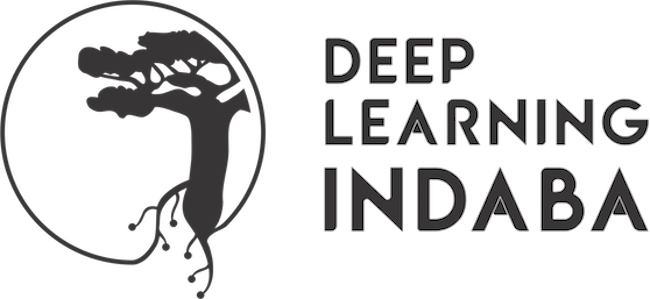